# Z-Image (Lumina-2) : Génération Avancée avec ComfyUI

**Module :** 02-Images-Advanced
**Niveau :** Avancé
**Durée estimée :** 30 minutes

## Introduction
Ce notebook explore l'utilisation de **Z-Image** (basé sur l'architecture Lumina-2 de Google Gemma), un modèle de génération d'images haute qualité, intégré via ComfyUI.

### Particularités de Z-Image
- Architecture **Lumina-2** (Gemma-2 Text Encoder).
- Utilisation d'un **VAE Vidéo** (Qwen/Wan) pour une meilleure compression.
- Nécessite un **patch dimensionnel** (LatentUnsqueeze) pour la compatibilité dans ComfyUI.

## Prérequis
- Environnement GenAI démarré (`docker compose up`)
- Service `comfyui-qwen` actif et authentifié.
- Fichier `.env` configuré avec le token d'authentification.


In [1]:
# 1. Configuration de l'environnement
import os
import requests
import json
import time
from PIL import Image
from io import BytesIO
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Chargement des variables d'environnement
load_dotenv("../00-GenAI-Environment/.env")

COMFYUI_URL = "http://localhost:8188"
COMFYUI_TOKEN = os.getenv("COMFYUI_AUTH_TOKEN")

if not COMFYUI_TOKEN:
    raise ValueError("❌ Token COMFYUI_AUTH_TOKEN manquant dans le fichier .env")

HEADERS = {"Authorization": f"Bearer {COMFYUI_TOKEN}"}

print("✅ Configuration chargée")
print(f"Target URL: {COMFYUI_URL}")

✅ Configuration chargée
Target URL: http://localhost:8188


In [2]:
# 2. Définition du Workflow Z-Image
# Ce JSON correspond au graphe nodal ComfyUI pour Z-Image

z_image_workflow = {
    "3": {
        "class_type": "KSampler",
        "inputs": {
            "seed": 42, # Changé dynamiquement plus bas
            "steps": 20,
            "cfg": 3.0,
            "sampler_name": "euler",
            "scheduler": "normal",
            "denoise": 1.0,
            "model": ["4", 0],
            "positive": ["6", 0],
            "negative": ["7", 0],
            "latent_image": ["5", 0]
        }
    },
    "4": {
        "class_type": "UnetLoaderGGUF",
        "inputs": {
            "unet_name": "z_image_turbo-Q5_K_M.gguf"
        }
    },
    "5": {
        "class_type": "EmptyLatentImage",
        "inputs": {
            "width": 1024,
            "height": 1024,
            "batch_size": 1
        }
    },
    "6": {
        "class_type": "CLIPTextEncode",
        "inputs": {
            "text": "", # Rempli dynamiquement
            "clip": ["10", 0]
        }
    },
    "7": {
        "class_type": "CLIPTextEncode",
        "inputs": {
            "text": "low quality, blurry, watermarks, text, ugly, deformed",
            "clip": ["10", 0]
        }
    },
    "8": {
        "class_type": "VAEDecode",
        "inputs": {
            "samples": ["12", 0],  # Connecté à LatentUnsqueeze
            "vae": ["11", 0]
        }
    },
    "9": {
        "class_type": "SaveImage",
        "inputs": {
            "filename_prefix": "Notebook_Z-Image",
            "images": ["8", 0]
        }
    },
    "10": {
        "class_type": "CLIPLoaderGGUF",
        "inputs": {
            "clip_name": "gemma-3-4b-it-Q4_K_M.gguf",
            "type": "lumina2"
        }
    },
    "11": {
        "class_type": "VAELoader",
        "inputs": {
            "vae_name": "qwen_image_vae.safetensors"
        }
    },
    "12": {
        "class_type": "LatentUnsqueeze",
        "inputs": {
            "samples": ["3", 0]
        }
    }
}

print("Workflow défini")

Workflow défini


In [3]:
# 3. Fonction de Génération Helper
def generate_z_image(prompt, seed=None):
    if seed is None:
        import random
        seed = random.randint(0, 1000000000)
    
    # Mise à jour du prompt et seed
    workflow = z_image_workflow.copy()
    workflow["6"]["inputs"]["text"] = prompt
    workflow["3"]["inputs"]["seed"] = seed
    
    payload = {"prompt": workflow}
    
    print(f"🚀 Envoi de la requête... (Seed: {seed})")
    resp = requests.post(f"{COMFYUI_URL}/prompt", json=payload, headers=HEADERS)
    
    if resp.status_code != 200:
        print(f"❌ Erreur API: {resp.text}")
        return None
        
    prompt_id = resp.json()["prompt_id"]
    print(f"✅ Tâche ID: {prompt_id} - En attente de génération...")
    
    # Polling simple
    while True:
        history_resp = requests.get(f"{COMFYUI_URL}/history/{prompt_id}", headers=HEADERS)
        if history_resp.status_code == 200 and history_resp.json():
            break
        time.sleep(1)
    
    print("✅ Génération terminée!")
    
    # Récupération image
    history = history_resp.json()[prompt_id]
    output_data = history['outputs']['9']['images'][0]
    
    filename = output_data['filename']
    subfolder = output_data['subfolder']
    img_type = output_data['type']
    
    img_url = f"{COMFYUI_URL}/view?filename={filename}&subfolder={subfolder}&type={img_type}"
    img_resp = requests.get(img_url, headers=HEADERS)
    
    return Image.open(BytesIO(img_resp.content))


🚀 Envoi de la requête... (Seed: 510721493)
✅ Tâche ID: b2100bd2-c602-4821-98e6-e68f9347c6a1 - En attente de génération...


✅ Génération terminée!


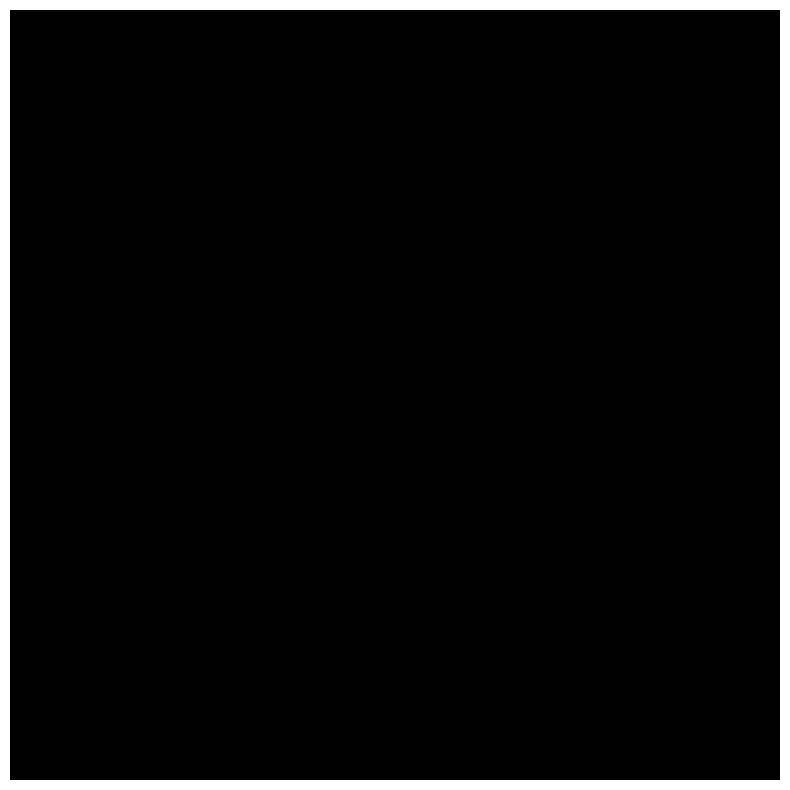

In [4]:
# 4. Test de Génération
prompt = "Cinematic photography of a samurai robot in a neon cyberpunk city, raining, reflections, 8k, highly detailed"
image = generate_z_image(prompt)

if image:
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

## Exercice
Essayez de modifier le prompt pour générer un paysage naturel (e.g., "A peaceful mountain lake at sunrise") et observez comment Z-Image gère les textures organiques par rapport aux styles cyberpunk.